# Advanced IR Models

## N-Grams

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import snowball
import re

def my_tokenizer(text):
        sw=stopwords.words('english')
        stemmer=snowball.SnowballStemmer(language="english")
        tokens=word_tokenize(text)
        pruned=[stemmer.stem(t) for t in tokens if re.search(r"^[a-zA-Z]",t) and not t in sw]
        return pruned

#initialize the vectorizer considering bigrams
vectorizer=TfidfVectorizer(tokenizer=my_tokenizer,ngram_range=(1,2))

#Add the files in the corpus, a document on each line
corpus=["This document describes racing cars",
        "This document is about videos of table games",
        "This is a nice racing video game",
         "Video killed the radio star"]

#creates the model
model=vectorizer.fit_transform(corpus)
#print the dictionary
print(vectorizer.get_feature_names_out())

['car' 'describ' 'describ race' 'document' 'document describ'
 'document video' 'game' 'kill' 'kill radio' 'nice' 'nice race' 'race'
 'race car' 'race video' 'radio' 'radio star' 'star' 'tabl' 'tabl game'
 'video' 'video game' 'video kill' 'video tabl']


/Users/mdipenta/webIR2024/.venv/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Running a query

In [3]:
query=vectorizer.transform(["video game"])

cos=cosine_similarity(query,model)
print(cos)

[[0.         0.30389824 0.59923094 0.11299246]]


## Latent Semantic Indexing

In [4]:
from gensim import corpora
from gensim import models
from gensim import similarities
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import snowball
import re

def my_tokenizer(text):
    """tokenization function"""
    sw=stopwords.words('english')
    stemmer=snowball.SnowballStemmer(language="english")
    tokens=word_tokenize(text)
    pruned=[stemmer.stem(t.lower()) for t in tokens \
            if re.search(r"^[a-zA-Z]",t) and not t.lower() in sw]
    return pruned

documents=["Indian government goes for open source software",
"Debian 3.0 Woody released",
"Wine 2.0 released with fixes for Gentoo 1.4 and Debian 3.0",
"gnuPOD released: iPOD on Linux… with GPLed software",
"Gentoo servers running at open source mySQL database",
"Dolly the sheep not totally identical clone",
"DNA news: introduced low-cost human genome DNA chip",
"Malaria-parasite genome database on the Web",
"UK sets up genome bank to protect rare sheep breeds",
"Dolly's DNA damaged"]

Creating LSI models and adding similarities...

In [5]:
texts=[]
for d in documents:
    # creates an array of tokenized documents
    texts.append(my_tokenizer(d))

#creates the dictionary for the document corpus
dictionary = corpora.Dictionary(texts)
#creates a bag of word corpus
bow_corpus=[dictionary.doc2bow(text) for text in texts]

#creates a tf-idf model from the bag of word corpus
tfidf = models.TfidfModel(bow_corpus)

#extracts the tf-idf corpus
corpus_tfidf = tfidf[bow_corpus]

#creates the LSI model, with 2 topics
lsi_model=models.LsiModel(corpus_tfidf,num_topics=2,id2word=dictionary)

#creates an index that facilitates the computation of similarities
index = similarities.MatrixSimilarity(lsi_model[corpus_tfidf])

Printing similarities...

In [6]:
print(list(index)[0])
print(list(index)[5])

[1.0000001  0.97902197 0.9843578  0.9853968  0.99798703 0.10885489
 0.13524207 0.68249047 0.19551672 0.11114562]
[ 0.10885489 -0.09597263 -0.06798209 -0.06199703  0.17167735  1.
  0.9996466   0.8008437   0.9961556   0.9999973 ]


Running a query

In [7]:
#tokenizes the query
query_document = my_tokenizer("DNA")

#indexes the query using the documents' dictionary
query_bow = dictionary.doc2bow(query_document)
query_lsi = lsi_model[query_bow]  # convert the query to LSI space


#computes the similarity between the query and the documents
sims = index[query_lsi]
print(list(enumerate(sims)))

[(0, 0.118368536), (1, -0.08643689), (2, -0.05842559), (3, -0.05243706), (4, 0.18110284), (5, 0.9999541), (6, 0.99985534), (7, 0.8065415), (8, 0.9969488), (9, 0.99997354)]


Unsurprisingly, the query is very similar to the last 5 documents, even if not all of them contain the term “DNA”

Getting the LSI model:

In [8]:
corpus_lsi=lsi_model[corpus_tfidf]
for doc in corpus_lsi:
    scores=[topic_score for (topic_id, topic_score) in doc]
    print(scores)

[0.32258570270232195, -0.011813322545720484]
[0.6534290583018239, 0.1112154310261179]
[0.7148643126316747, 0.10110548067678715]
[0.3631170170144967, 0.0491371699007727]
[0.4371576359197479, -0.04389094154630967]
[0.03384809269857176, -0.46626716310180805]
[0.06473954701070801, -0.6514432585710749]
[0.1601939884848445, -0.1846639499143885]
[0.03956125166498163, -0.24486415600169917]
[0.05646889808275636, -0.7538129187682796]


Printing topics...

In [9]:
print(lsi_model.show_topic(0))

[('debian', 0.4434854694998984), ('releas', 0.39387184658100166), ('woodi', 0.3514242109573059), ('gentoo', 0.2958535529232635), ('fix', 0.2830600541023718), ('wine', 0.28306005410237167), ('open', 0.17417437157754553), ('sourc', 0.17417437157754548), ('softwar', 0.15920294729105086), ('databas', 0.14610110507158386)]


In [10]:
print(lsi_model.show_topic(1))

[('dna', -0.5359729615542276), ('dolli', -0.4042679632122833), ('damag', -0.40273638947754503), ('news', -0.18203378118963026), ('low-cost', -0.18203378118963026), ('introduc', -0.18203378118963026), ('human', -0.18203378118963026), ('chip', -0.18203378118963023), ('genom', -0.1758161678537646), ('clone', -0.17564030867034555)]


Let's now determine the optimal number of topics by analyzing the model's coherence

Text(0, 0.5, 'Coherence score')

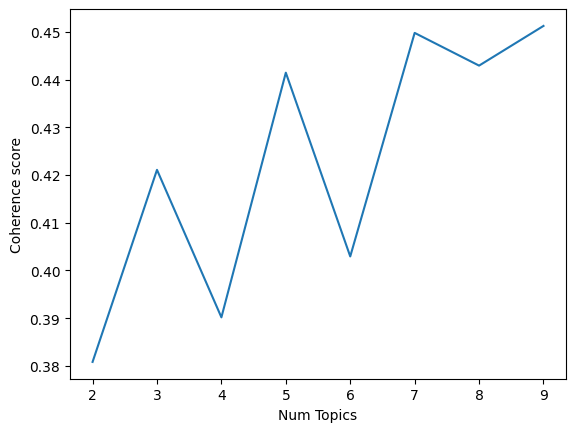

In [13]:
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

coherence_values = []
model_list = []
for num_topics in range(2, 10):
    model = models.LsiModel(corpus_tfidf, num_topics=num_topics, id2word=dictionary)
    model_list.append(model)
    coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence_values.append(coherencemodel.get_coherence())

plt.plot(range(2, 10), coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")

Text(0, 0.5, 'Coherence score')

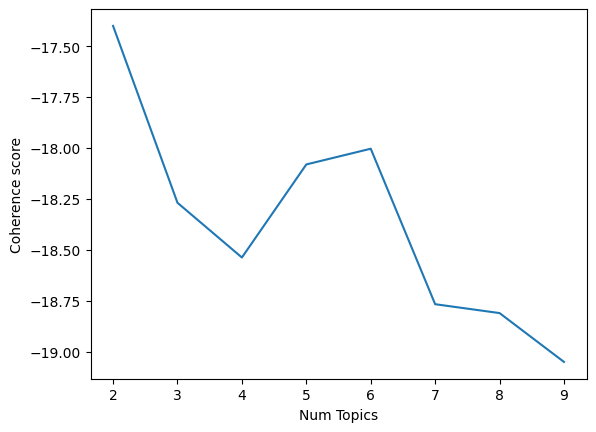

In [15]:
# compute coherence models using u-mass
coherence_values_umass = []
model_list_umass = []
for num_topics in range(2, 10):
    model = models.LsiModel(corpus_tfidf, num_topics=num_topics, id2word=dictionary)
    model_list_umass.append(model)
    coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='u_mass')
    coherence_values_umass.append(coherencemodel.get_coherence())

plt.plot(range(2, 10), coherence_values_umass)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
